<a href="https://colab.research.google.com/github/MAristyaP/Mesin_Learning2023/blob/main/LabWork10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'A patchwork about 911. The 11 stories from 11 directors from 11 countries are sometimes humoristic, sometimes boring (the first one, for example), sometimes used to say to Americans "we have had more deaths than you, and you supported the murderers", sometimes really weird (but highly symbolic and interesting). I really loved the Claude Lelouch (personal live of a couple in New-York, showing that our day-to-day "problems" are unimportant), Shoei Imamura (bizarre, strongly anti-wars in general), and Idrissa Ouedraogo (funny, typical African optimism despite terrible day to day misery), and Youssef Chahine (an Egyptian intellectual, pro-peace, having moral difficulties to accept the U.S. policy towards Arab countries) I am really pleased to see that many Americans liked this movie. It shows that we (or they ? I am still Belgian, but living in Texas for 12 years) are still interested by other cultures, and able to question past and present actions of our government, like we sho

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  4,   1,  43, ...,   0,   0,   0],
       [  1,  13, 131, ...,   0,   0,   0],
       [  1,   1,  21, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'A patchwork about 911. The 11 stories from 11 directors from 11 countries are sometimes humoristic, sometimes boring (the first one, for example), sometimes used to say to Americans "we have had more deaths than you, and you supported the murderers", sometimes really weird (but highly symbolic and interesting). I really loved the Claude Lelouch (personal live of a couple in New-York, showing that our day-to-day "problems" are unimportant), Shoei Imamura (bizarre, strongly anti-wars in general), and Idrissa Ouedraogo (funny, typical African optimism despite terrible day to day misery), and Youssef Chahine (an Egyptian intellectual, pro-peace, having moral difficulties to accept the U.S. policy towards Arab countries) I am really pleased to see that many Americans liked this movie. It shows that we (or they ? I am still Belgian, but living in Texas for 12 years) are still interested by other cultures, and able to question past and present actions of our government, like we s

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00128148]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00128148]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 99ms/step - loss: 0.6309 - accuracy: 0.5882 - val_loss: 0.4653 - val_accuracy: 0.7865
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.4249 - accuracy: 0.8115 - val_loss: 0.3808 - val_accuracy: 0.8380
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3549 - accuracy: 0.8456 - val_loss: 0.3528 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3278 - accuracy: 0.8605 - val_loss: 0.3395 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3144 - accuracy: 0.8648 - val_loss: 0.3257 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3085 - accuracy: 0.8681 - val_loss: 0.3205 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3027 - accuracy: 0.8704 - val_loss: 0.3190 - val_accuracy:

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 54ms/step - loss: 0.3414 - accuracy: 0.8599
Test Loss: 0.3414188027381897
Test Accuracy: 0.8599200248718262


(0.0, 0.6475463375449181)

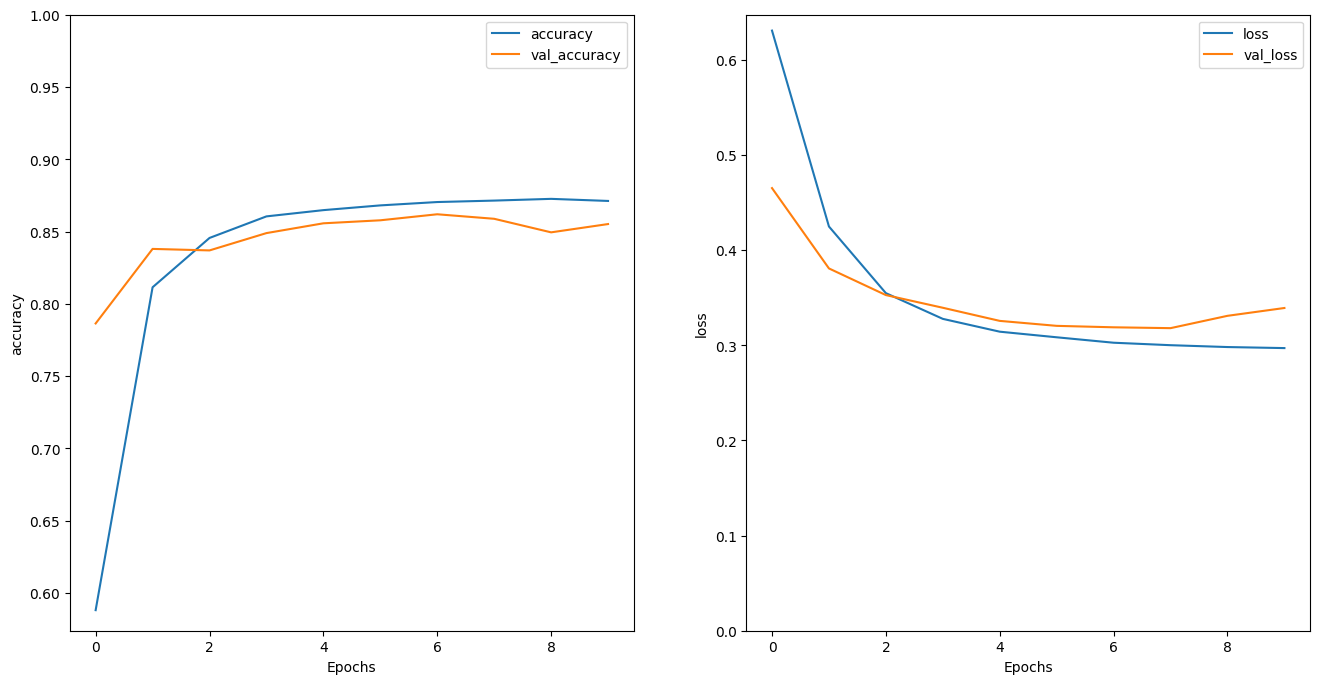

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


In [28]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 155ms/step - loss: 0.6285 - accuracy: 0.5887 - val_loss: 0.4560 - val_accuracy: 0.7693
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3846 - accuracy: 0.8315 - val_loss: 0.3521 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3380 - accuracy: 0.8564 - val_loss: 0.3316 - val_accuracy: 0.8583
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3226 - accuracy: 0.8631 - val_loss: 0.3316 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3137 - accuracy: 0.8669 - val_loss: 0.3270 - val_accuracy: 0.8656
Epoch 6/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3079 - accuracy: 0.8680 - val_loss: 0.3195 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3041 - accuracy: 0.8700 - val_loss: 0.3202 - val_ac

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 54ms/step - loss: 0.3311 - accuracy: 0.8591
Test Loss: 0.33114302158355713
Test Accuracy: 0.8590800166130066


In [33]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.7338265]]


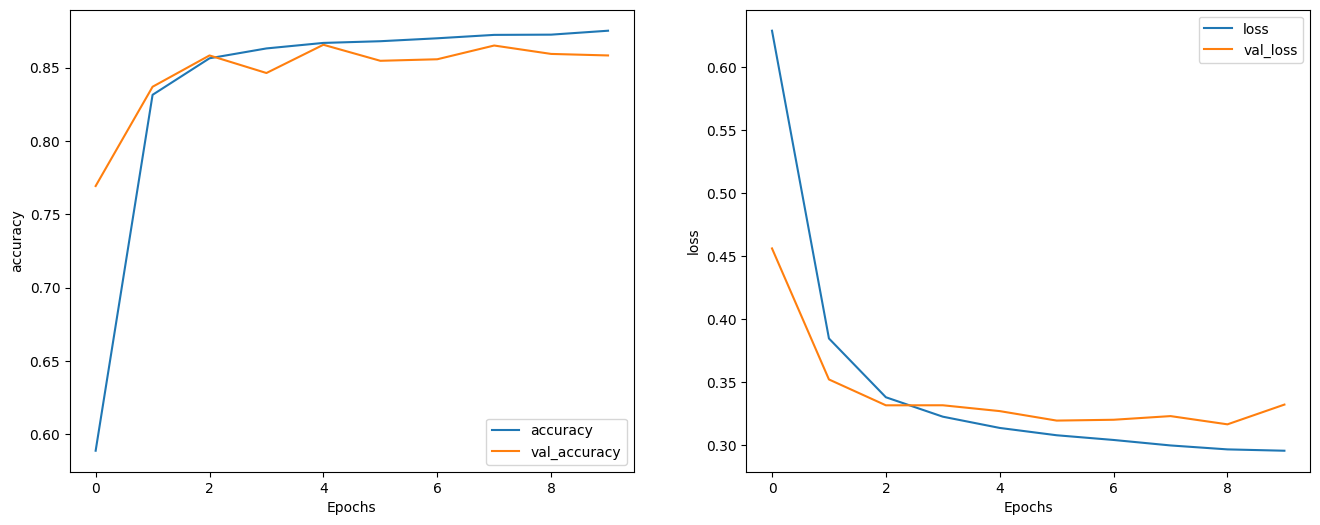

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

LabWork 2

In [35]:
import tensorflow as tf
import numpy as np
import os
import time

In [38]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [39]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [40]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [41]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [43]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [136]:
ids_from_chars=tf.keras.layers.StringLookup(vocabulary=list(vocab),mask_token=None)

In [45]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [137]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [47]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [48]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [49]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [50]:
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)

In [51]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [52]:
seq_length=100

In [69]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [138]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()

In [83]:
for seq in sequences.take(5):
    print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [84]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [85]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [86]:
dataset = sequences.map(split_input_target)

In [88]:
for input_example,target_example in dataset.take(1):
    print("Input :",text_from_ids(input_example))
    print("Target:",text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [89]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [90]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [91]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [92]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [93]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [94]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
sampled_indices=tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()

In [96]:
sampled_indices

array([ 3, 55, 37, 44, 16, 48, 42, 15, 45, 58, 11, 42,  3, 29, 59, 33,  1,
       39, 36, 14, 21, 45, 30, 45, 55, 27, 16, 10,  1, 48, 32,  5, 44, 65,
       44, 56, 37, 24, 12,  8, 22, 11, 33,  6, 33, 61,  3, 15, 57, 30, 63,
       24,  0, 21, 61, 60, 55,  0, 44, 49, 15, 53,  4, 50, 60,  9, 46, 34,
       17, 28, 32, 52, 22, 62,  5, 24, 46, 43, 22, 33, 51, 33, 11,  7, 40,
        1, 44, 19, 44, 37, 34, 12, 30, 15, 48, 29, 48, 34,  3, 33])

In [99]:
print("Input:\n",text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n",text_from_ids(sampled_indices))

Input:
 b'is yond, that vainly lends his light\nTo grubs and eyeless skulls? as I discern,\nIt burneth in the Ca'

Next Char Predictions:
 b"!pXeCicBfs:c!PtT\nZWAHfQfpNC3\niS&ezeqXK;-I:T'Tv!BrQxK[UNK]Hvup[UNK]ejBn$ku.gUDOSmIw&KgdITlT:,a\neFeXU;QBiPiU!T"


In [100]:
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [101]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.188686, shape=(), dtype=float32)


In [102]:
tf.exp(example_batch_mean_loss).numpy()

65.93609

In [103]:
model.compile(optimizer='adam',loss=loss)

In [104]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [105]:
EPOCHS=20

In [106]:
history=model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 16s 61ms/step - loss: 2.7251
Epoch 2/20
172/172 [==============================] - 13s 61ms/step - loss: 1.9928
Epoch 3/20
172/172 [==============================] - 12s 62ms/step - loss: 1.7125
Epoch 4/20
172/172 [==============================] - 12s 61ms/step - loss: 1.5504
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4517
Epoch 6/20
172/172 [==============================] - 12s 59ms/step - loss: 1.3823
Epoch 7/20
172/172 [==============================] - 12s 60ms/step - loss: 1.3298
Epoch 8/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2844
Epoch 9/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2436
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2040
Epoch 11/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1649
Epoch 12/20
172/172 [==============================] - 12s 61ms/step - loss: 1.1227
E

In [141]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [142]:
one_step_model=OneStep(
    model=model,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars)

TypeError: ignored

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)